In [1]:
from tensorflow.python.client import device_lib
import numpy as np
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import keras
from pre_process import PreProcess
from atari_model1 import Atari_Model1
import environment
from ring_buf import RingBuf
from logger import Logger
from agent import Agent
import environment
import model_loading
# Import the gym module
import gym
from sklearn.preprocessing import OneHotEncoder

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


['/device:GPU:0']

In [2]:
onehot_encoder = OneHotEncoder(sparse=False)

# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

# Render
# env.render()

toy = False
frames = []
rewards = []
if toy:
    ring_buf_size = 10000
    max_iter = 100000 # total of iterations
    iter_loop = 10000
else:
    ring_buf_size = 100000
    max_iter = 10000000 # total of iterations
    iter_loop = 100000
    
ring_buf = RingBuf(ring_buf_size)
# model = Atari_Model2(4)
model = Atari_Model1(4)
pre_process = PreProcess()
logger = Logger(10)
agent = Agent()

iteration = 1 # initialize counter
update_model_loop = 10000 # copy model every this value

# First enrich the whole ring_buf
while not ring_buf.isFull():
    agent.reset_env(env, pre_process)
    
    while not agent.is_terminate:
        # Perform a random action, returns the new frame, reward and whether the game is over
        action = env.action_space.sample()
        agent.do_action(env, pre_process, action)
        
        ring_buf.append((agent.start_states, action, agent.total_reward, agent.end_states, agent.lose_life))
        if(len(ring_buf) % 10000 == 0):
            print("ring buf size: ", len(ring_buf),"/",ring_buf_size)
        
print("Enriched ring buf, ", len(ring_buf),"isFull: ",  ring_buf.isFull())

onehot_encoder.fit((np.asarray(ring_buf.data)).transpose()[1].reshape(-1,1))

/home/laikasin93/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/laikasin93/python/atari_game/atari_model1.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), activation="relu", strides=(4, 4))`
  conv_1 = keras.layers.convolutional.Convolution2D(16, 8, 8, subsample=(4, 4), activation='relu')(frames_input)
/home/laikasin93/python/atari_game/atari_model1.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu", strides=(2, 2))`
  conv_2 = keras.layers.convolutional.Convolution2D(32, 4, 4, subsample=(2, 2), activation='relu')(conv_1)
/home/laikasin93/python/atari_game/atari_model1.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  model = keras.models.Model(input=[frames_input], 

ring buf size:  10000 / 100000
ring buf size:  20000 / 100000
ring buf size:  30000 / 100000
ring buf size:  40000 / 100000
ring buf size:  50000 / 100000
ring buf size:  60000 / 100000
ring buf size:  70000 / 100000
ring buf size:  80000 / 100000
ring buf size:  90000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  1

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [ ]:
while iteration < max_iter:
    agent.reset_env(env, pre_process)
    
    while not agent.is_terminate:
        # Iterate with DQN
        loss = environment.q_iteration(env, model.model, model.target_model, agent, iteration, 
                    ring_buf, onehot_encoder, pre_process)


        iteration = iteration + 1
        if(iteration == max_iter):
            break
        else:
            if(iteration%update_model_loop == 0):
                model.copy_model()
                # save model weights in yml, h5
                save_model(model.model)
            if(iteration%iter_loop == 0):
                print("Progess : ", iteration,"/",max_iter)
                agent.iteration = iteration
                # evaluate and save stat in file
                environment.evaluate(logger, model, agent, pre_process)
    # Render
#     env.render()

In [33]:
model.model.summary()
# plot_model(model.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
frames (InputLayer)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________


In [69]:
import os
cwd = os.getcwd()
cwd=cwd+"/atari.mp4"

# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')


video_recorder = None
video_recorder = gym.wrappers.monitoring.video_recorder.VideoRecorder(
        env, cwd, enabled=cwd is not None)

agent.reset_env(env, pre_process)
# Render
env.unwrapped.render()
video_recorder.capture_frame()

while not agent.is_terminate:
    action = choose_best_action(model.model, agent.end_states, env.action_space.n)
    agent.do_action(env, pre_process, action)
    reward += agent.total_reward
#     frame, reward, is_terminate, _ = env.step(env.action_space.sample())
    # Render
    env.unwrapped.render()
    video_recorder.capture_frame()
#     time.sleep(1)
video_recorder.close()
video_recorder.enabled = False

/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-alias

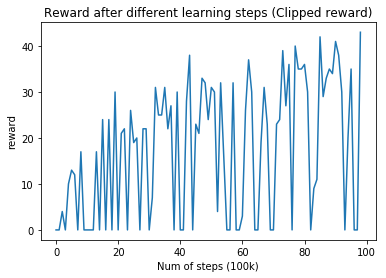

In [98]:
import pandas
%matplotlib inline
import matplotlib.pyplot as plt


progress_df = pandas.read_csv("model_learn_progress.txt")
plt.plot(progress_df['ADV_RETURN'])
plt.ylabel('reward')
plt.xlabel('Num of steps (100k)')
plt.title('Reward after different learning steps (Clipped reward)')
# plt.show()
plt.savefig('progress.jpg')

In [ ]:
# while not is_terminate:
#     frame, reward, is_terminate, live_info = env.step(env.action_space.sample())
#     print(is_terminate, live_info)

In [71]:
# pre_process  = PreProcess()

# import matplotlib.pyplot as plt
# import gym
# # Create the environment and display the initial state
# env = gym.make('BreakoutDeterministic-v4')
# observation = env.reset()
# env.step(0)
# env.step(1)
# frame, reward, is_terminate, _ = env.step(0)
# firstframe = env.render(mode = 'rgb_array')
# fig,ax = plt.subplots()
# im = ax.imshow(firstframe)
# fig,ax = plt.subplots()
# im = ax.imshow(frame)


# fig,ax = plt.subplots()
# frame_processed = pre_process.preprocess(firstframe)
# im = ax.imshow(pre_process.preprocess(firstframe))
# print(frame_processed.shape)

In [106]:
# def evaluate_random(logger, model, agent, pre_process):

#     print("Evaluation started.")
#     for i in range(0, logger.evaluation_number):
#         agent.reset_env(env, pre_process)

#         while not agent.is_terminate:
#             action = env.action_space.sample()
#             agent.do_action(env, pre_process, action)
#             logger.write(agent)
# logger = Logger(5)
# evaluate_random(logger, model, agent, pre_process)

In [ ]:
# load_model(model)